AE beginning taken from "https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac", which we will use for a "quick start" to develop our own AE.

1. Import libraries and MNIST dataset
We can import the dataset using the library torchvision. We download the training and the test datasets and we transform the image datasets into Tensor. We don’t need to normalize the images because the datasets contain colored images. After we divide the training dataset into training and validation sets.The random_split provides a random partition for these two sets. The DataLoader is used to create data loaders for the training, validation, and test sets, which are split into mini-batches. The batchsize is the number of samples used in one iteration during the training of the model.

In [6]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

2. Define Convolutional Autoencoder
Here, we define the Autoencoder with Convolutional layers. It will be composed of two classes: one for the encoder and one for the decoder. The encoder will contain three convolutional layers and two fully connected layers. Some batch norm layers are added as regularizers. The decoder will have the same architecture but in inverse order.

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

3. Initialize Loss function and the optimizer
We need to define the building blocks before training the autoencoder:

torch.device to train the model with a hardware accelerator like the GPU
the Encoder and the Decoder networks, that will be moved to the device
nn.MSEloss and torch.optim.Adam

In [8]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

4. Train and evaluate model
We define a function to train the AE model. First, we pass the input images to the encoder. Later, the encoded data is passed to the decoder and then we compute the reconstruction loss with loss_fn(x_hat,x). After we clear the gradient to not accumulate other values, we perform backpropagation and at the end, we compute the gradient by calling opt.step().

In [12]:

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Once the training function is created, we define a function to evaluate the performance of the model. As before, we pass the image to the encoder. The encoded image is passed to the decoder. Then, we store all the image batches and the reconstruction into two different lists, that will be used to calculate the test loss.

In [9]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

We also would like to see the reconstructed images during each epoch of the training. The goal is to understand how the autoencoder is learning from the input images.

In [10]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

Let’s break the test code into little pieces:

test_dataset[i][0].unsqueeze(0) is used to extract the ith image from the test dataset and then it will be increased by 1 dimension on the 0 axis. This step is needed to pass the image to the autoencoder.
decoder(encoder(img))is used to obtain the reconstructed image
plt.imshow(img.cpu().squeeze().numpy())is used to plot the original image. squeeze()removes the dimension added before and is essential to visualize the image. numpy() transforms a tensor into a n-dimensional array, which is the only type of object accepted by the function plt.imshow. numpy() returns a copy of the tensor object into CPU memory.
Now we can finally begin to train the model on the training set and evaluate it on the validation set.

	 partial train loss (single batch): 0.253092
	 partial train loss (single batch): 0.246094
	 partial train loss (single batch): 0.240621
	 partial train loss (single batch): 0.236286
	 partial train loss (single batch): 0.231538
	 partial train loss (single batch): 0.228540
	 partial train loss (single batch): 0.224885
	 partial train loss (single batch): 0.222509
	 partial train loss (single batch): 0.220120
	 partial train loss (single batch): 0.217992
	 partial train loss (single batch): 0.215562
	 partial train loss (single batch): 0.213429
	 partial train loss (single batch): 0.211595
	 partial train loss (single batch): 0.209597
	 partial train loss (single batch): 0.207237
	 partial train loss (single batch): 0.205022
	 partial train loss (single batch): 0.203047
	 partial train loss (single batch): 0.201474
	 partial train loss (single batch): 0.199288
	 partial train loss (single batch): 0.197733
	 partial train loss (single batch): 0.195651
	 partial train loss (single batch

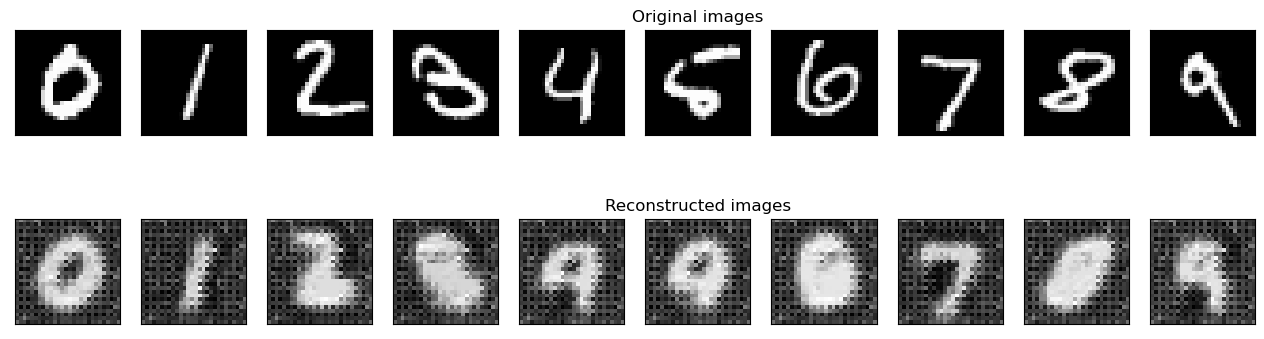

	 partial train loss (single batch): 0.065827
	 partial train loss (single batch): 0.064838
	 partial train loss (single batch): 0.065925
	 partial train loss (single batch): 0.065510
	 partial train loss (single batch): 0.066976
	 partial train loss (single batch): 0.064677
	 partial train loss (single batch): 0.064843
	 partial train loss (single batch): 0.065648
	 partial train loss (single batch): 0.063640
	 partial train loss (single batch): 0.064520
	 partial train loss (single batch): 0.063539
	 partial train loss (single batch): 0.063789
	 partial train loss (single batch): 0.063313
	 partial train loss (single batch): 0.063811
	 partial train loss (single batch): 0.063734
	 partial train loss (single batch): 0.064479
	 partial train loss (single batch): 0.063393
	 partial train loss (single batch): 0.062512
	 partial train loss (single batch): 0.063053
	 partial train loss (single batch): 0.061297
	 partial train loss (single batch): 0.062299
	 partial train loss (single batch

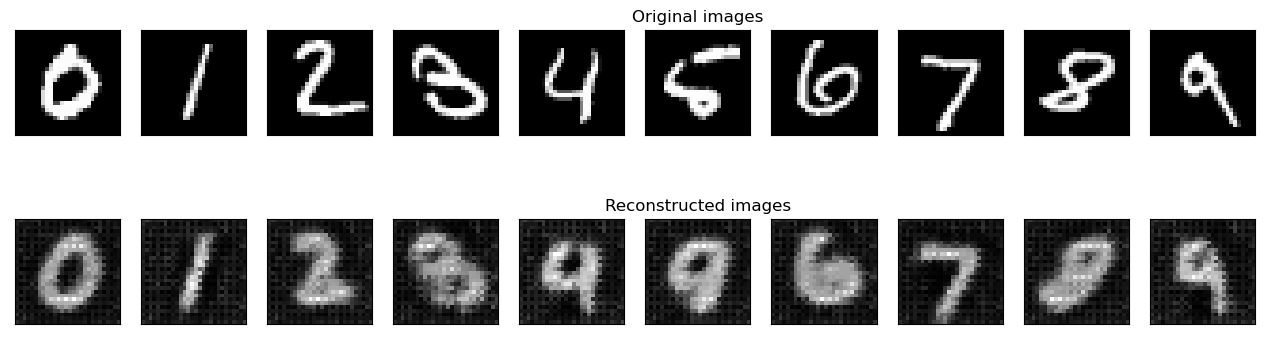

	 partial train loss (single batch): 0.045988
	 partial train loss (single batch): 0.045746
	 partial train loss (single batch): 0.046824
	 partial train loss (single batch): 0.046482
	 partial train loss (single batch): 0.048159
	 partial train loss (single batch): 0.045494
	 partial train loss (single batch): 0.046696
	 partial train loss (single batch): 0.047353
	 partial train loss (single batch): 0.045641
	 partial train loss (single batch): 0.046668
	 partial train loss (single batch): 0.045524
	 partial train loss (single batch): 0.046295
	 partial train loss (single batch): 0.045398
	 partial train loss (single batch): 0.046522
	 partial train loss (single batch): 0.045917
	 partial train loss (single batch): 0.047365
	 partial train loss (single batch): 0.046257
	 partial train loss (single batch): 0.045452
	 partial train loss (single batch): 0.046259
	 partial train loss (single batch): 0.044110
	 partial train loss (single batch): 0.045540
	 partial train loss (single batch

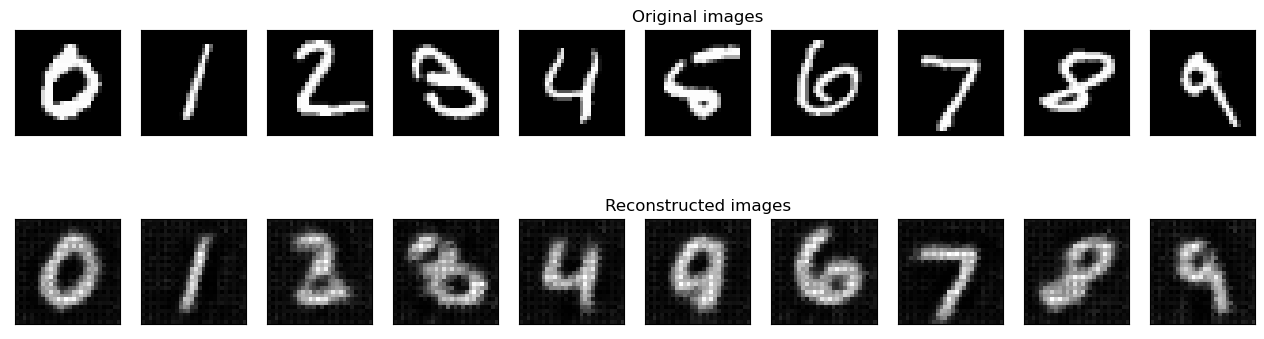

	 partial train loss (single batch): 0.036427
	 partial train loss (single batch): 0.036971
	 partial train loss (single batch): 0.037732
	 partial train loss (single batch): 0.037344
	 partial train loss (single batch): 0.039141
	 partial train loss (single batch): 0.035861
	 partial train loss (single batch): 0.037729
	 partial train loss (single batch): 0.037687
	 partial train loss (single batch): 0.036881
	 partial train loss (single batch): 0.037239
	 partial train loss (single batch): 0.036444
	 partial train loss (single batch): 0.037723
	 partial train loss (single batch): 0.036340
	 partial train loss (single batch): 0.037587
	 partial train loss (single batch): 0.036873
	 partial train loss (single batch): 0.037973
	 partial train loss (single batch): 0.037529
	 partial train loss (single batch): 0.036962
	 partial train loss (single batch): 0.038032
	 partial train loss (single batch): 0.035371
	 partial train loss (single batch): 0.036583
	 partial train loss (single batch

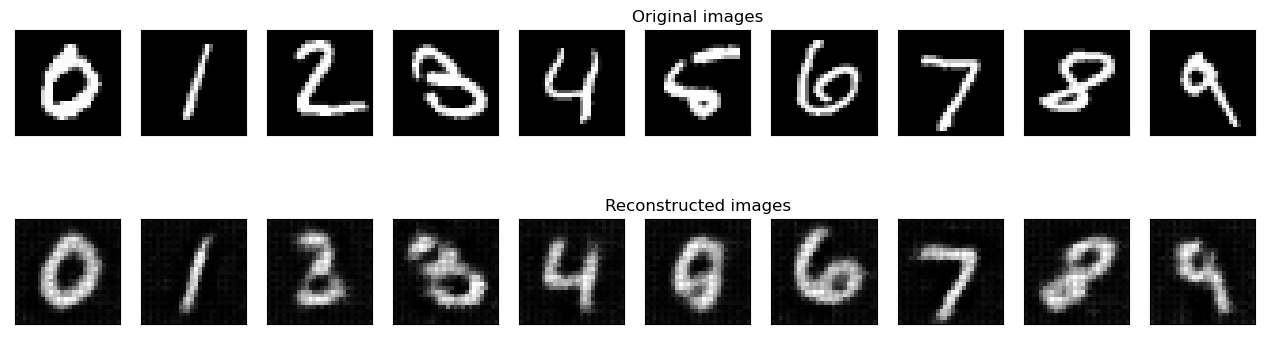

	 partial train loss (single batch): 0.032397
	 partial train loss (single batch): 0.032642
	 partial train loss (single batch): 0.033631
	 partial train loss (single batch): 0.032924
	 partial train loss (single batch): 0.035060
	 partial train loss (single batch): 0.031592
	 partial train loss (single batch): 0.033676
	 partial train loss (single batch): 0.033066
	 partial train loss (single batch): 0.032815
	 partial train loss (single batch): 0.033059
	 partial train loss (single batch): 0.032450
	 partial train loss (single batch): 0.033850
	 partial train loss (single batch): 0.032304
	 partial train loss (single batch): 0.033531
	 partial train loss (single batch): 0.032752
	 partial train loss (single batch): 0.033704
	 partial train loss (single batch): 0.033696
	 partial train loss (single batch): 0.033087
	 partial train loss (single batch): 0.034201
	 partial train loss (single batch): 0.031691
	 partial train loss (single batch): 0.032876
	 partial train loss (single batch

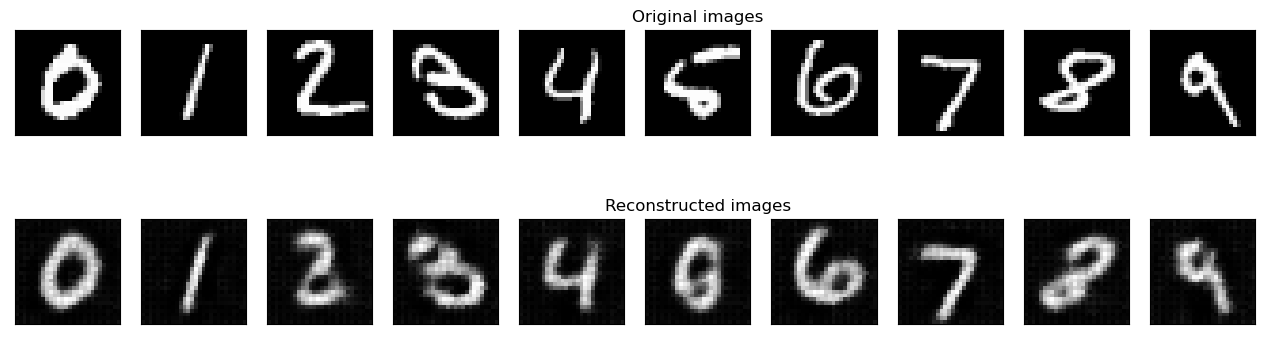

	 partial train loss (single batch): 0.030622
	 partial train loss (single batch): 0.030792
	 partial train loss (single batch): 0.031846
	 partial train loss (single batch): 0.030938
	 partial train loss (single batch): 0.033201
	 partial train loss (single batch): 0.029553
	 partial train loss (single batch): 0.031852
	 partial train loss (single batch): 0.031287
	 partial train loss (single batch): 0.031167
	 partial train loss (single batch): 0.031121
	 partial train loss (single batch): 0.030770
	 partial train loss (single batch): 0.032225
	 partial train loss (single batch): 0.030623
	 partial train loss (single batch): 0.031607
	 partial train loss (single batch): 0.030861
	 partial train loss (single batch): 0.032093
	 partial train loss (single batch): 0.032021
	 partial train loss (single batch): 0.031529
	 partial train loss (single batch): 0.032521
	 partial train loss (single batch): 0.030015
	 partial train loss (single batch): 0.031348
	 partial train loss (single batch

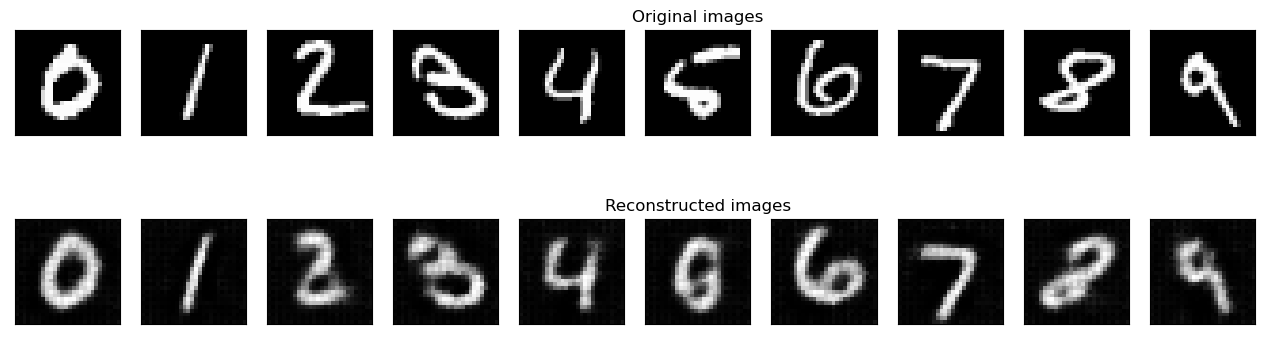

	 partial train loss (single batch): 0.029803
	 partial train loss (single batch): 0.029746
	 partial train loss (single batch): 0.030637
	 partial train loss (single batch): 0.029834
	 partial train loss (single batch): 0.032023
	 partial train loss (single batch): 0.028486
	 partial train loss (single batch): 0.030768
	 partial train loss (single batch): 0.030189
	 partial train loss (single batch): 0.030365
	 partial train loss (single batch): 0.030029
	 partial train loss (single batch): 0.029635
	 partial train loss (single batch): 0.031168
	 partial train loss (single batch): 0.029698
	 partial train loss (single batch): 0.030472
	 partial train loss (single batch): 0.029786
	 partial train loss (single batch): 0.030903
	 partial train loss (single batch): 0.031178
	 partial train loss (single batch): 0.030690
	 partial train loss (single batch): 0.031473
	 partial train loss (single batch): 0.029157
	 partial train loss (single batch): 0.030166
	 partial train loss (single batch

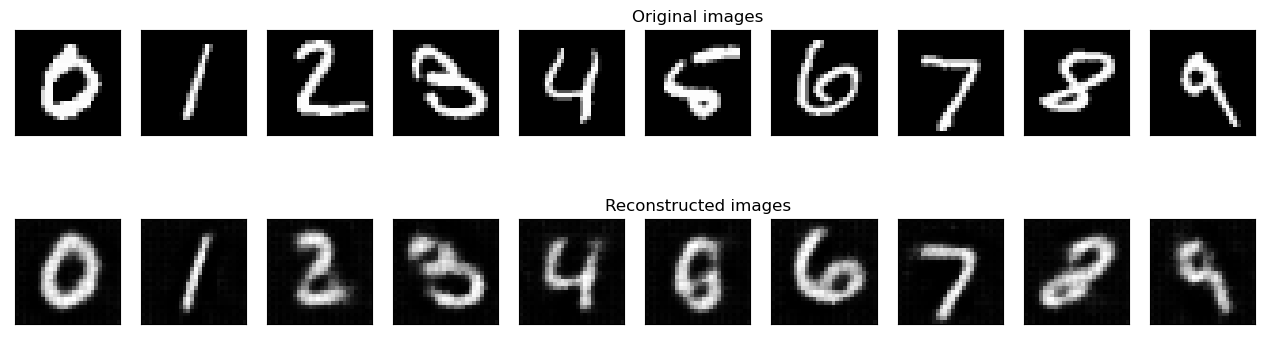

	 partial train loss (single batch): 0.029091
	 partial train loss (single batch): 0.028919
	 partial train loss (single batch): 0.029860
	 partial train loss (single batch): 0.028895
	 partial train loss (single batch): 0.031322
	 partial train loss (single batch): 0.027745
	 partial train loss (single batch): 0.029972
	 partial train loss (single batch): 0.029325
	 partial train loss (single batch): 0.029632
	 partial train loss (single batch): 0.029411
	 partial train loss (single batch): 0.028923
	 partial train loss (single batch): 0.030409
	 partial train loss (single batch): 0.029051
	 partial train loss (single batch): 0.029629
	 partial train loss (single batch): 0.029165
	 partial train loss (single batch): 0.030230
	 partial train loss (single batch): 0.030527
	 partial train loss (single batch): 0.029965
	 partial train loss (single batch): 0.030761
	 partial train loss (single batch): 0.028584
	 partial train loss (single batch): 0.029515
	 partial train loss (single batch

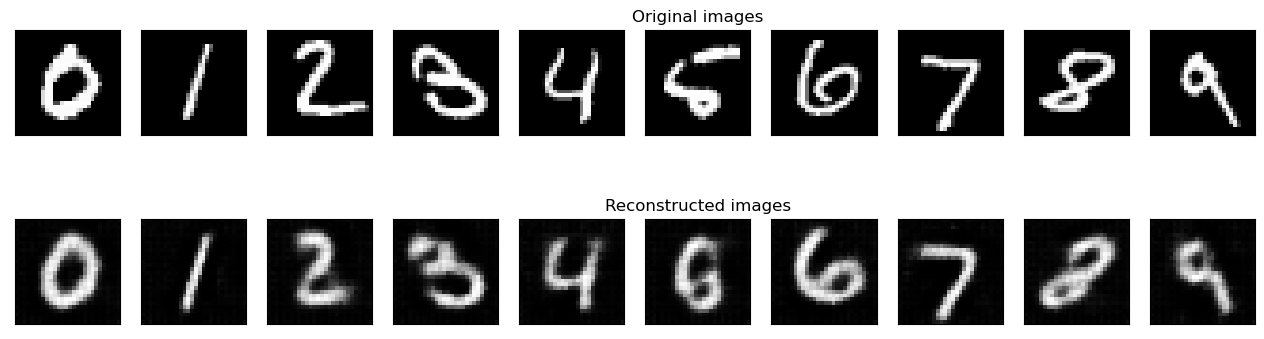

	 partial train loss (single batch): 0.028444
	 partial train loss (single batch): 0.028260
	 partial train loss (single batch): 0.029386
	 partial train loss (single batch): 0.028301
	 partial train loss (single batch): 0.030685
	 partial train loss (single batch): 0.027013
	 partial train loss (single batch): 0.029344
	 partial train loss (single batch): 0.028776
	 partial train loss (single batch): 0.029114
	 partial train loss (single batch): 0.028860
	 partial train loss (single batch): 0.028337
	 partial train loss (single batch): 0.029810
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.029061
	 partial train loss (single batch): 0.028549
	 partial train loss (single batch): 0.029676
	 partial train loss (single batch): 0.030067
	 partial train loss (single batch): 0.029350
	 partial train loss (single batch): 0.030221
	 partial train loss (single batch): 0.028076
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch

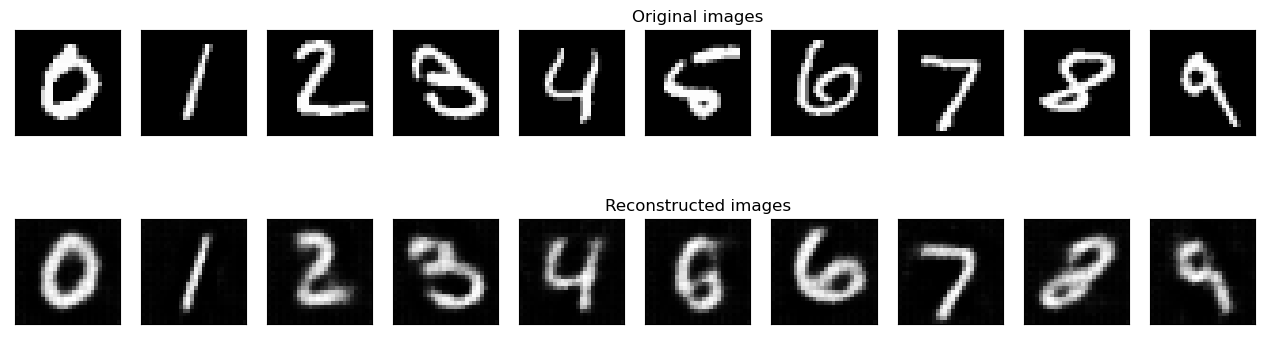

	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.027811
	 partial train loss (single batch): 0.029071
	 partial train loss (single batch): 0.027908
	 partial train loss (single batch): 0.030273
	 partial train loss (single batch): 0.026640
	 partial train loss (single batch): 0.028833
	 partial train loss (single batch): 0.028380
	 partial train loss (single batch): 0.028723
	 partial train loss (single batch): 0.028429
	 partial train loss (single batch): 0.028021
	 partial train loss (single batch): 0.029363
	 partial train loss (single batch): 0.028190
	 partial train loss (single batch): 0.028711
	 partial train loss (single batch): 0.028198
	 partial train loss (single batch): 0.029242
	 partial train loss (single batch): 0.029724
	 partial train loss (single batch): 0.028755
	 partial train loss (single batch): 0.029732
	 partial train loss (single batch): 0.027663
	 partial train loss (single batch): 0.028623
	 partial train loss (single batch

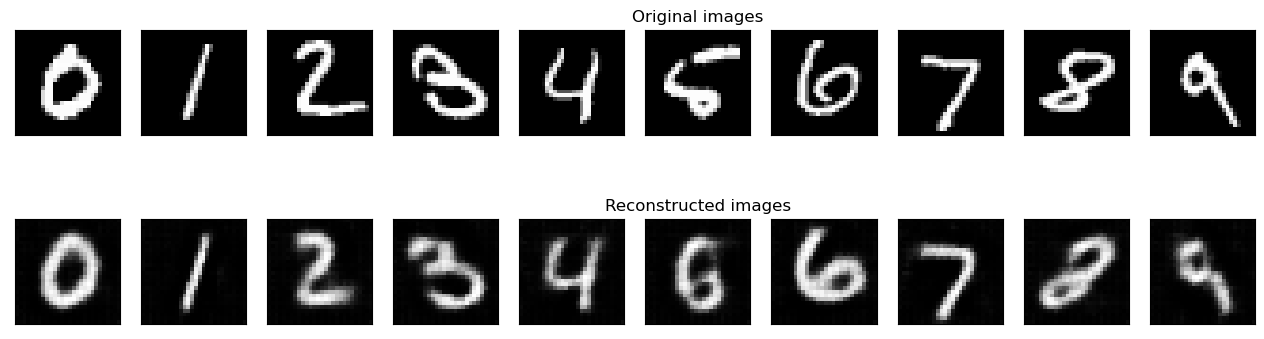

	 partial train loss (single batch): 0.027760
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.028782
	 partial train loss (single batch): 0.027581
	 partial train loss (single batch): 0.029911
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch): 0.028443
	 partial train loss (single batch): 0.028093
	 partial train loss (single batch): 0.028383
	 partial train loss (single batch): 0.028182
	 partial train loss (single batch): 0.027705
	 partial train loss (single batch): 0.028958
	 partial train loss (single batch): 0.027911
	 partial train loss (single batch): 0.028461
	 partial train loss (single batch): 0.027781
	 partial train loss (single batch): 0.028889
	 partial train loss (single batch): 0.029400
	 partial train loss (single batch): 0.028301
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.027371
	 partial train loss (single batch): 0.028251
	 partial train loss (single batch

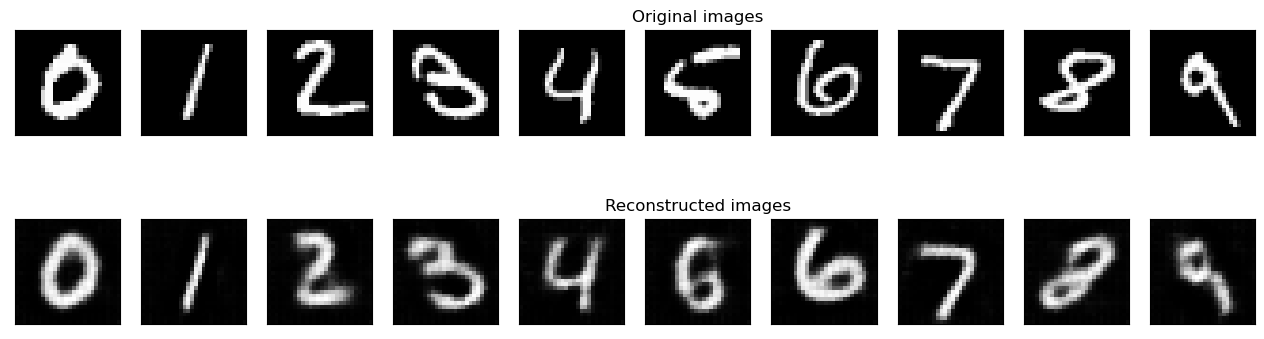

	 partial train loss (single batch): 0.027516
	 partial train loss (single batch): 0.027091
	 partial train loss (single batch): 0.028474
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.029737
	 partial train loss (single batch): 0.025977
	 partial train loss (single batch): 0.028136
	 partial train loss (single batch): 0.027849
	 partial train loss (single batch): 0.028076
	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.027381
	 partial train loss (single batch): 0.028549
	 partial train loss (single batch): 0.027647
	 partial train loss (single batch): 0.028150
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.028561
	 partial train loss (single batch): 0.029107
	 partial train loss (single batch): 0.028005
	 partial train loss (single batch): 0.029150
	 partial train loss (single batch): 0.027144
	 partial train loss (single batch): 0.027987
	 partial train loss (single batch

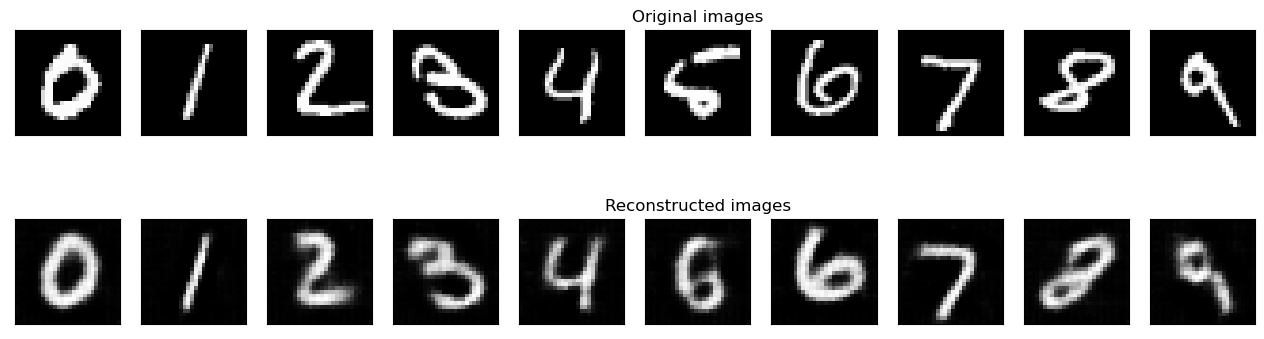

	 partial train loss (single batch): 0.027153
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.028198
	 partial train loss (single batch): 0.026963
	 partial train loss (single batch): 0.029452
	 partial train loss (single batch): 0.025778
	 partial train loss (single batch): 0.027918
	 partial train loss (single batch): 0.027628
	 partial train loss (single batch): 0.027839
	 partial train loss (single batch): 0.027740
	 partial train loss (single batch): 0.027236
	 partial train loss (single batch): 0.028346
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.027932
	 partial train loss (single batch): 0.027355
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.028897
	 partial train loss (single batch): 0.027820
	 partial train loss (single batch): 0.028957
	 partial train loss (single batch): 0.026990
	 partial train loss (single batch): 0.027752
	 partial train loss (single batch

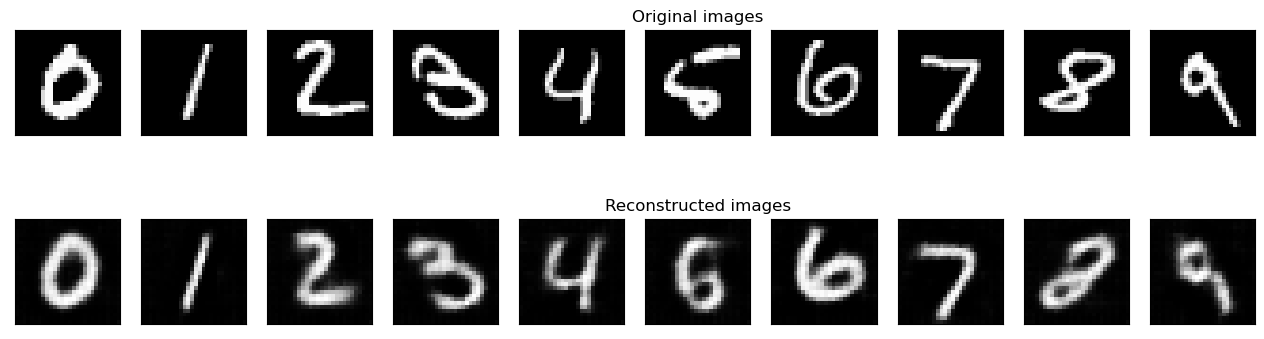

	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.026524
	 partial train loss (single batch): 0.027916
	 partial train loss (single batch): 0.026671
	 partial train loss (single batch): 0.029197
	 partial train loss (single batch): 0.025552
	 partial train loss (single batch): 0.027628
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.027659
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.026975
	 partial train loss (single batch): 0.028006
	 partial train loss (single batch): 0.027231
	 partial train loss (single batch): 0.027822
	 partial train loss (single batch): 0.027062
	 partial train loss (single batch): 0.028161
	 partial train loss (single batch): 0.028778
	 partial train loss (single batch): 0.027651
	 partial train loss (single batch): 0.028725
	 partial train loss (single batch): 0.026793
	 partial train loss (single batch): 0.027521
	 partial train loss (single batch

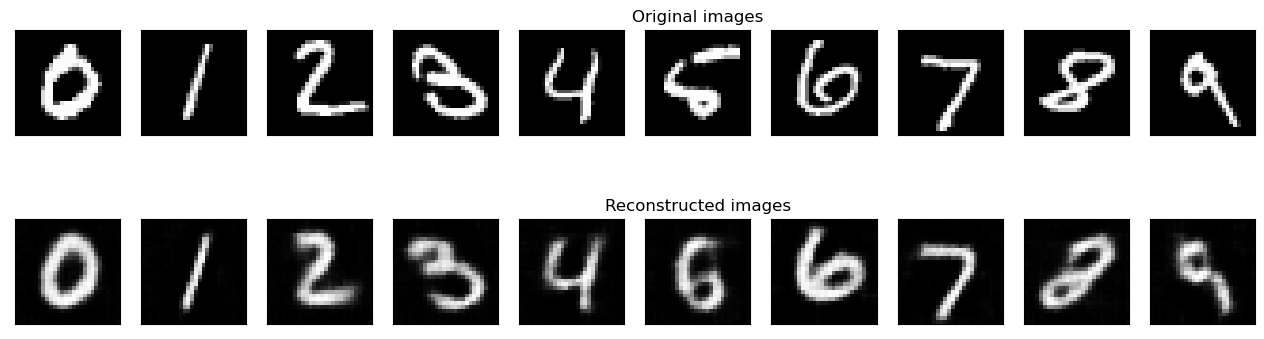

	 partial train loss (single batch): 0.026761
	 partial train loss (single batch): 0.026330
	 partial train loss (single batch): 0.027757
	 partial train loss (single batch): 0.026494
	 partial train loss (single batch): 0.029027
	 partial train loss (single batch): 0.025330
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.027235
	 partial train loss (single batch): 0.027413
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.026832
	 partial train loss (single batch): 0.027827
	 partial train loss (single batch): 0.026981
	 partial train loss (single batch): 0.027696
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.027949
	 partial train loss (single batch): 0.028600
	 partial train loss (single batch): 0.027478
	 partial train loss (single batch): 0.028458
	 partial train loss (single batch): 0.026705
	 partial train loss (single batch): 0.027200
	 partial train loss (single batch

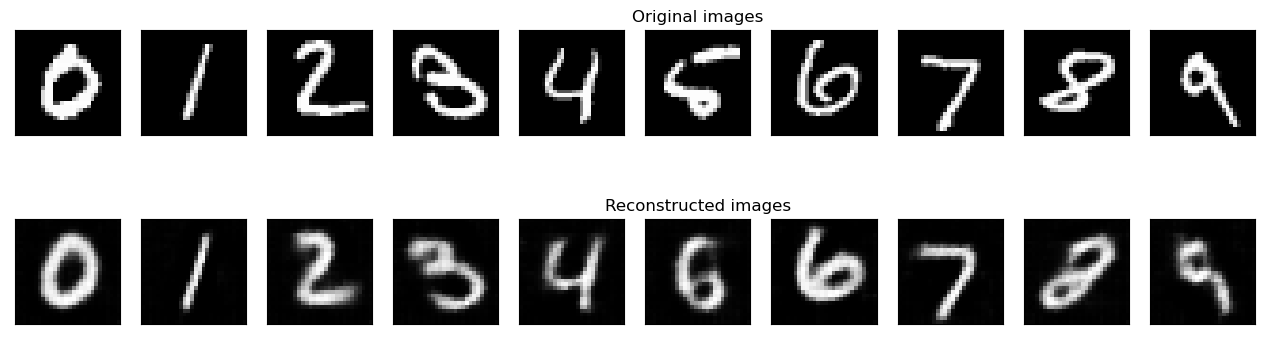

	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.026171
	 partial train loss (single batch): 0.027549
	 partial train loss (single batch): 0.026252
	 partial train loss (single batch): 0.028789
	 partial train loss (single batch): 0.025182
	 partial train loss (single batch): 0.027098
	 partial train loss (single batch): 0.026982
	 partial train loss (single batch): 0.027275
	 partial train loss (single batch): 0.027003
	 partial train loss (single batch): 0.026595
	 partial train loss (single batch): 0.027685
	 partial train loss (single batch): 0.026777
	 partial train loss (single batch): 0.027612
	 partial train loss (single batch): 0.026736
	 partial train loss (single batch): 0.027754
	 partial train loss (single batch): 0.028446
	 partial train loss (single batch): 0.027338
	 partial train loss (single batch): 0.028305
	 partial train loss (single batch): 0.026460
	 partial train loss (single batch): 0.027073
	 partial train loss (single batch

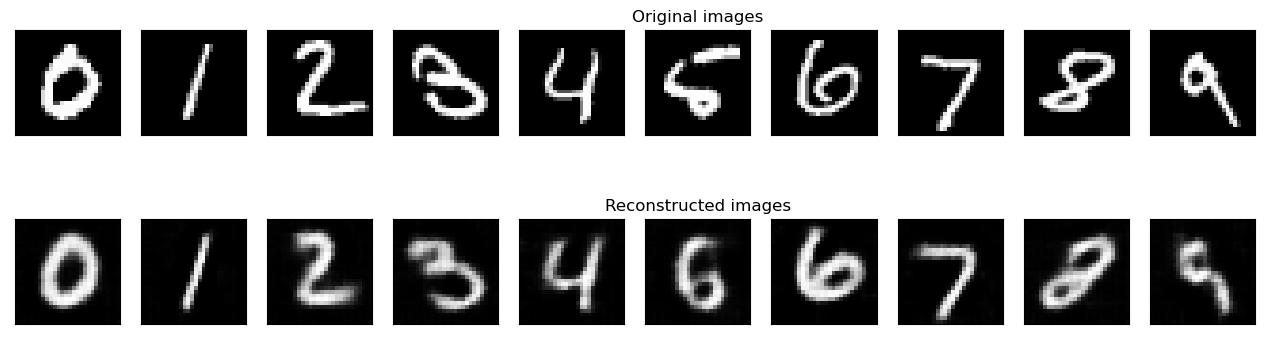

	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.025981
	 partial train loss (single batch): 0.027405
	 partial train loss (single batch): 0.026087
	 partial train loss (single batch): 0.028524
	 partial train loss (single batch): 0.025093
	 partial train loss (single batch): 0.026983
	 partial train loss (single batch): 0.026795
	 partial train loss (single batch): 0.027060
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.026485
	 partial train loss (single batch): 0.027502
	 partial train loss (single batch): 0.026623
	 partial train loss (single batch): 0.027393
	 partial train loss (single batch): 0.026626
	 partial train loss (single batch): 0.027672
	 partial train loss (single batch): 0.028200
	 partial train loss (single batch): 0.027289
	 partial train loss (single batch): 0.028211
	 partial train loss (single batch): 0.026353
	 partial train loss (single batch): 0.026917
	 partial train loss (single batch

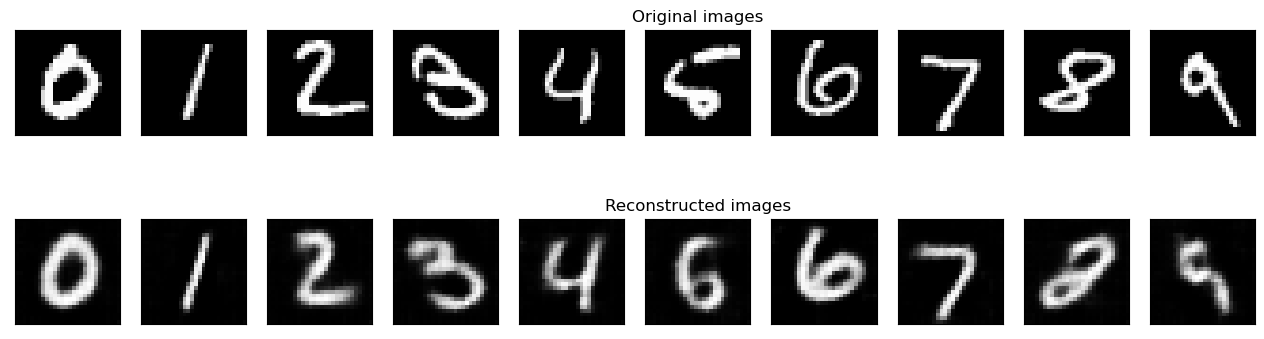

	 partial train loss (single batch): 0.026167
	 partial train loss (single batch): 0.025815
	 partial train loss (single batch): 0.027261
	 partial train loss (single batch): 0.025978
	 partial train loss (single batch): 0.028381
	 partial train loss (single batch): 0.024960
	 partial train loss (single batch): 0.026959
	 partial train loss (single batch): 0.026757
	 partial train loss (single batch): 0.026911
	 partial train loss (single batch): 0.026689
	 partial train loss (single batch): 0.026385
	 partial train loss (single batch): 0.027351
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.027262
	 partial train loss (single batch): 0.026540
	 partial train loss (single batch): 0.027591
	 partial train loss (single batch): 0.028098
	 partial train loss (single batch): 0.027214
	 partial train loss (single batch): 0.028145
	 partial train loss (single batch): 0.026284
	 partial train loss (single batch): 0.026784
	 partial train loss (single batch

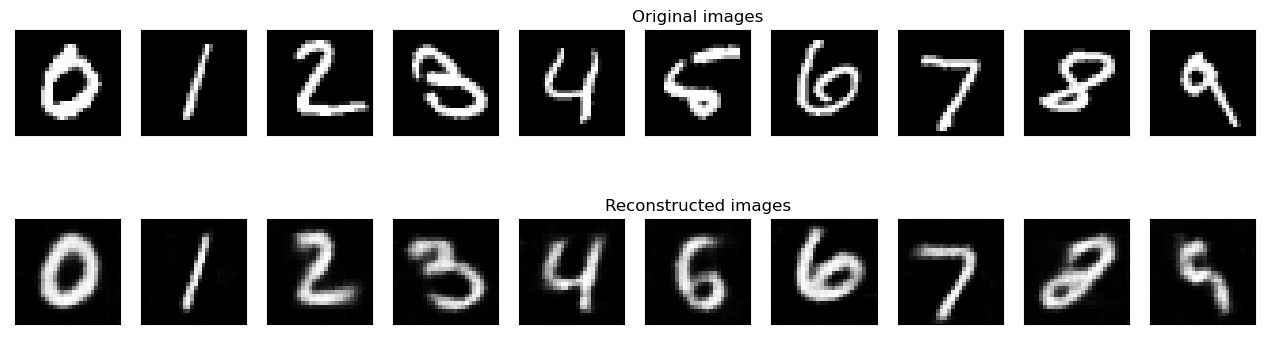

	 partial train loss (single batch): 0.025945
	 partial train loss (single batch): 0.025705
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch): 0.025852
	 partial train loss (single batch): 0.028260
	 partial train loss (single batch): 0.024842
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026753
	 partial train loss (single batch): 0.026523
	 partial train loss (single batch): 0.026157
	 partial train loss (single batch): 0.027222
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.026396
	 partial train loss (single batch): 0.027438
	 partial train loss (single batch): 0.027932
	 partial train loss (single batch): 0.027047
	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.026156
	 partial train loss (single batch): 0.026651
	 partial train loss (single batch

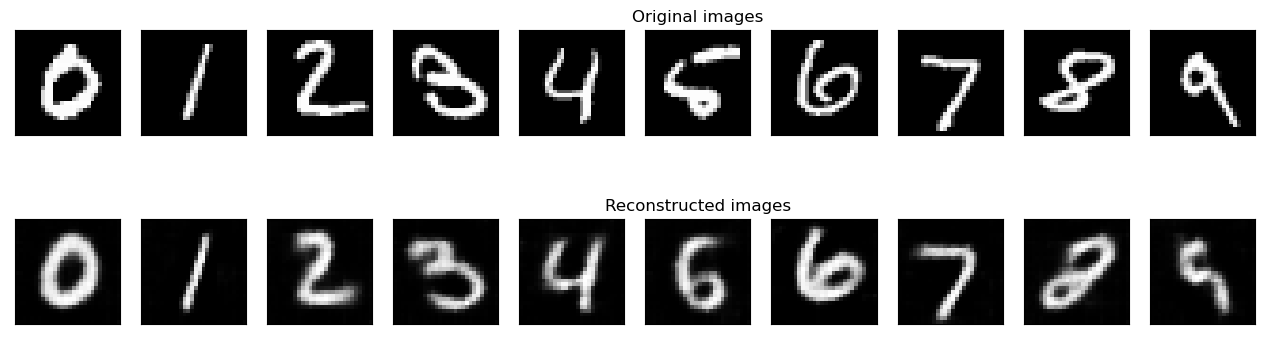

	 partial train loss (single batch): 0.025797
	 partial train loss (single batch): 0.025525
	 partial train loss (single batch): 0.027120
	 partial train loss (single batch): 0.025749
	 partial train loss (single batch): 0.028122
	 partial train loss (single batch): 0.024746
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.026398
	 partial train loss (single batch): 0.026638
	 partial train loss (single batch): 0.026359
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.027172
	 partial train loss (single batch): 0.026157
	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.026356
	 partial train loss (single batch): 0.027201
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.026934
	 partial train loss (single batch): 0.027877
	 partial train loss (single batch): 0.026049
	 partial train loss (single batch): 0.026513
	 partial train loss (single batch

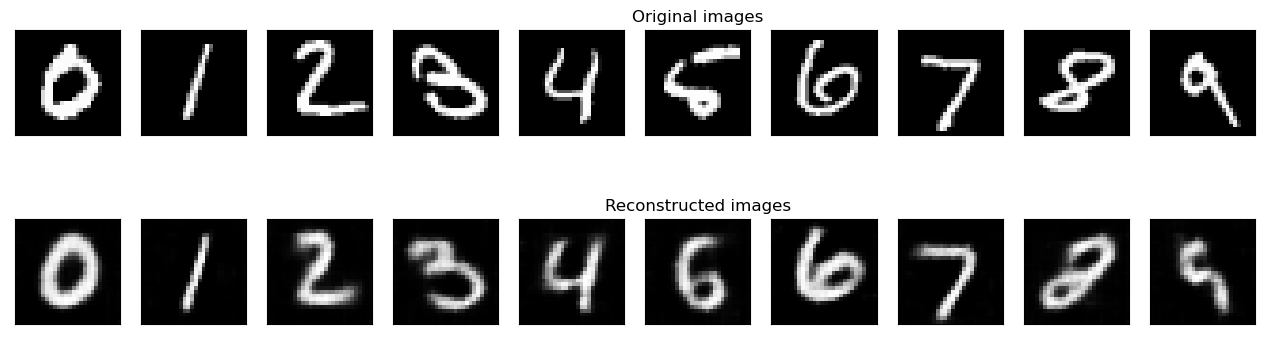

	 partial train loss (single batch): 0.025615
	 partial train loss (single batch): 0.025467
	 partial train loss (single batch): 0.026984
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.028073
	 partial train loss (single batch): 0.024675
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.026295
	 partial train loss (single batch): 0.026520
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.027017
	 partial train loss (single batch): 0.025990
	 partial train loss (single batch): 0.026855
	 partial train loss (single batch): 0.026224
	 partial train loss (single batch): 0.027025
	 partial train loss (single batch): 0.027640
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.025959
	 partial train loss (single batch): 0.026340
	 partial train loss (single batch

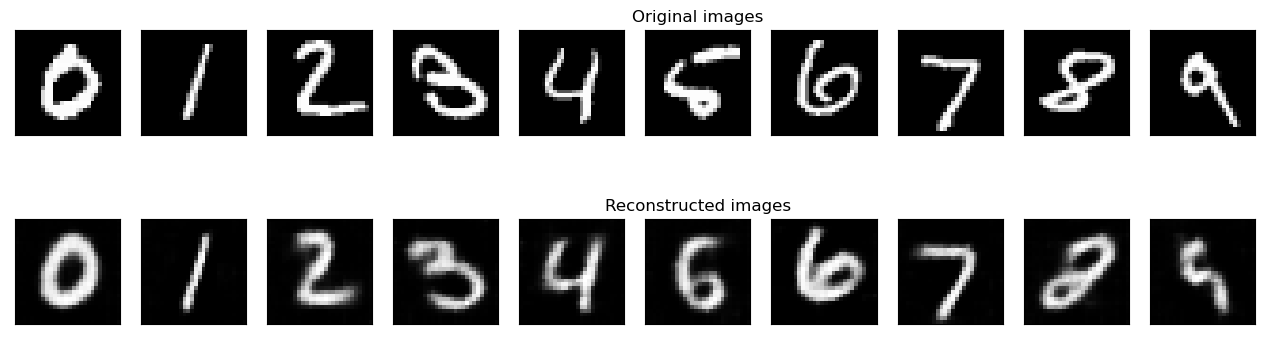

	 partial train loss (single batch): 0.025462
	 partial train loss (single batch): 0.025388
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.025505
	 partial train loss (single batch): 0.027913
	 partial train loss (single batch): 0.024567
	 partial train loss (single batch): 0.026372
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.026406
	 partial train loss (single batch): 0.026020
	 partial train loss (single batch): 0.025783
	 partial train loss (single batch): 0.026939
	 partial train loss (single batch): 0.025816
	 partial train loss (single batch): 0.026703
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.026925
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.026704
	 partial train loss (single batch): 0.027691
	 partial train loss (single batch): 0.025798
	 partial train loss (single batch): 0.026351
	 partial train loss (single batch

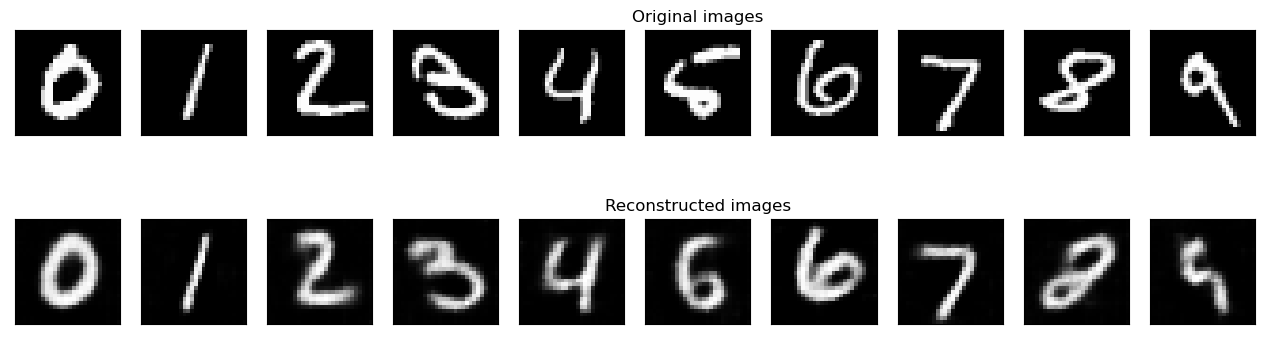

	 partial train loss (single batch): 0.025335
	 partial train loss (single batch): 0.025240
	 partial train loss (single batch): 0.026830
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.027815
	 partial train loss (single batch): 0.024451
	 partial train loss (single batch): 0.026273
	 partial train loss (single batch): 0.026039
	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.025958
	 partial train loss (single batch): 0.025683
	 partial train loss (single batch): 0.026818
	 partial train loss (single batch): 0.025692
	 partial train loss (single batch): 0.026658
	 partial train loss (single batch): 0.025977
	 partial train loss (single batch): 0.026817
	 partial train loss (single batch): 0.027352
	 partial train loss (single batch): 0.026684
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.025746
	 partial train loss (single batch): 0.026264
	 partial train loss (single batch

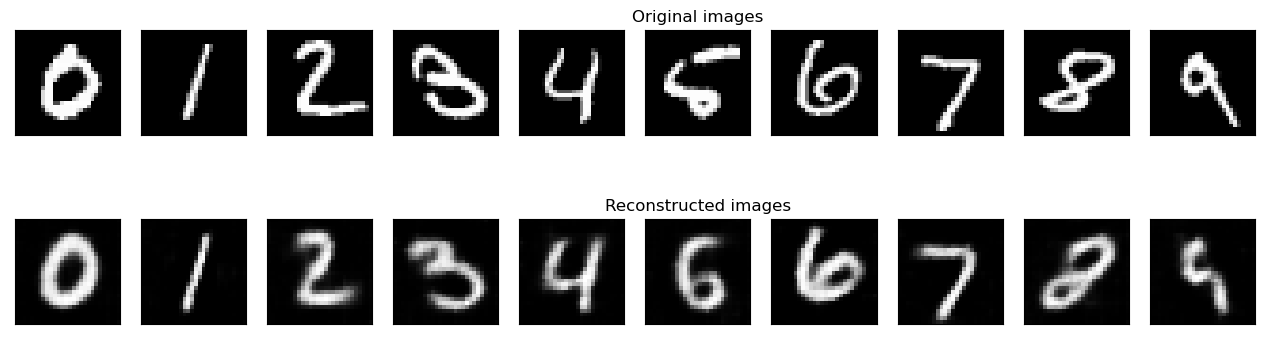

	 partial train loss (single batch): 0.025264
	 partial train loss (single batch): 0.025151
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.025231
	 partial train loss (single batch): 0.027677
	 partial train loss (single batch): 0.024426
	 partial train loss (single batch): 0.026215
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.025826
	 partial train loss (single batch): 0.025612
	 partial train loss (single batch): 0.026795
	 partial train loss (single batch): 0.025559
	 partial train loss (single batch): 0.026520
	 partial train loss (single batch): 0.025886
	 partial train loss (single batch): 0.026723
	 partial train loss (single batch): 0.027271
	 partial train loss (single batch): 0.026498
	 partial train loss (single batch): 0.027493
	 partial train loss (single batch): 0.025638
	 partial train loss (single batch): 0.026218
	 partial train loss (single batch

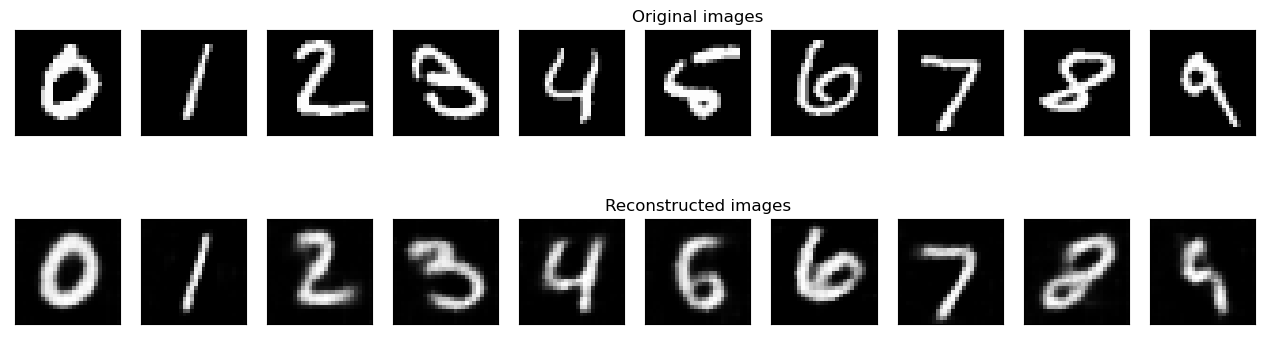

	 partial train loss (single batch): 0.025237
	 partial train loss (single batch): 0.025093
	 partial train loss (single batch): 0.026659
	 partial train loss (single batch): 0.025164
	 partial train loss (single batch): 0.027615
	 partial train loss (single batch): 0.024388
	 partial train loss (single batch): 0.026083
	 partial train loss (single batch): 0.025867
	 partial train loss (single batch): 0.026229
	 partial train loss (single batch): 0.025745
	 partial train loss (single batch): 0.025586
	 partial train loss (single batch): 0.026722
	 partial train loss (single batch): 0.025524
	 partial train loss (single batch): 0.026505
	 partial train loss (single batch): 0.025825
	 partial train loss (single batch): 0.026656
	 partial train loss (single batch): 0.027239
	 partial train loss (single batch): 0.026511
	 partial train loss (single batch): 0.027442
	 partial train loss (single batch): 0.025637
	 partial train loss (single batch): 0.026113
	 partial train loss (single batch

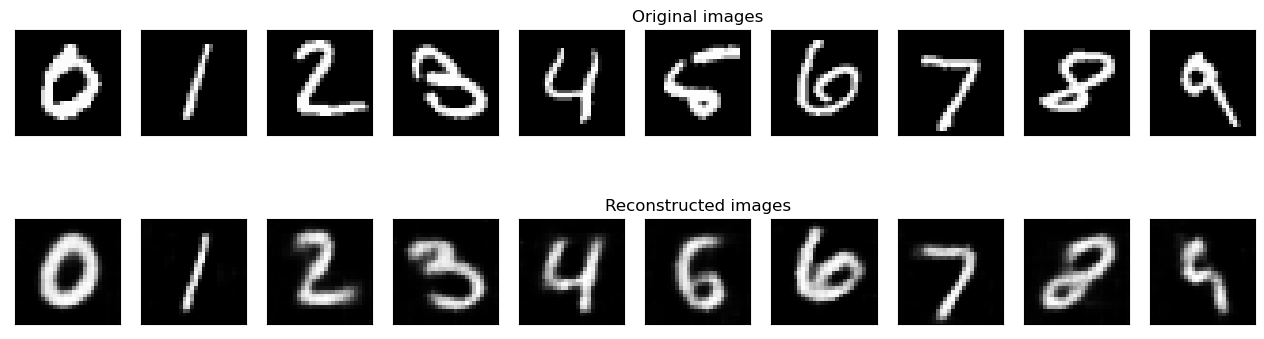

	 partial train loss (single batch): 0.025199
	 partial train loss (single batch): 0.024960
	 partial train loss (single batch): 0.026592
	 partial train loss (single batch): 0.025069
	 partial train loss (single batch): 0.027515
	 partial train loss (single batch): 0.024320
	 partial train loss (single batch): 0.025966
	 partial train loss (single batch): 0.025780
	 partial train loss (single batch): 0.026188
	 partial train loss (single batch): 0.025644
	 partial train loss (single batch): 0.025443
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.026419
	 partial train loss (single batch): 0.025705
	 partial train loss (single batch): 0.026561
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.026377
	 partial train loss (single batch): 0.027387
	 partial train loss (single batch): 0.025538
	 partial train loss (single batch): 0.026053
	 partial train loss (single batch

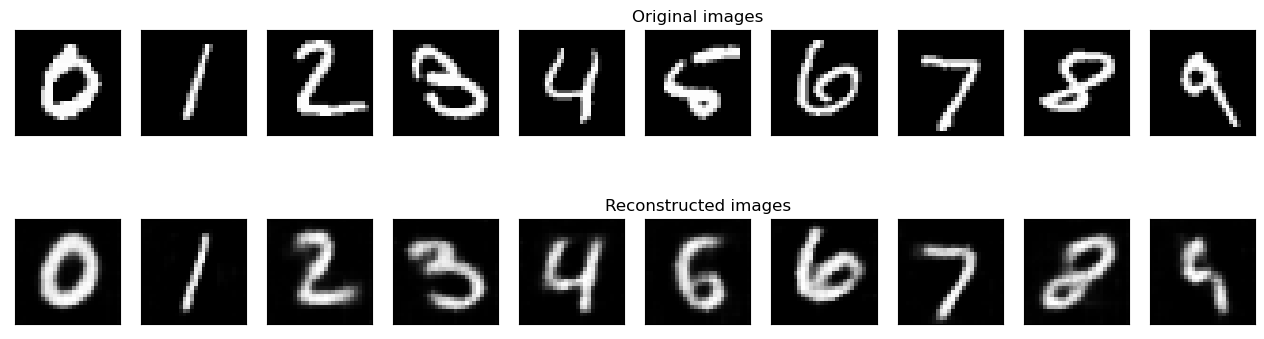

	 partial train loss (single batch): 0.025144
	 partial train loss (single batch): 0.024836
	 partial train loss (single batch): 0.026515
	 partial train loss (single batch): 0.025070
	 partial train loss (single batch): 0.027392
	 partial train loss (single batch): 0.024275
	 partial train loss (single batch): 0.025961
	 partial train loss (single batch): 0.025692
	 partial train loss (single batch): 0.026151
	 partial train loss (single batch): 0.025456
	 partial train loss (single batch): 0.025334
	 partial train loss (single batch): 0.026603
	 partial train loss (single batch): 0.025323
	 partial train loss (single batch): 0.026330
	 partial train loss (single batch): 0.025636
	 partial train loss (single batch): 0.026539
	 partial train loss (single batch): 0.027095
	 partial train loss (single batch): 0.026319
	 partial train loss (single batch): 0.027359
	 partial train loss (single batch): 0.025478
	 partial train loss (single batch): 0.026020
	 partial train loss (single batch

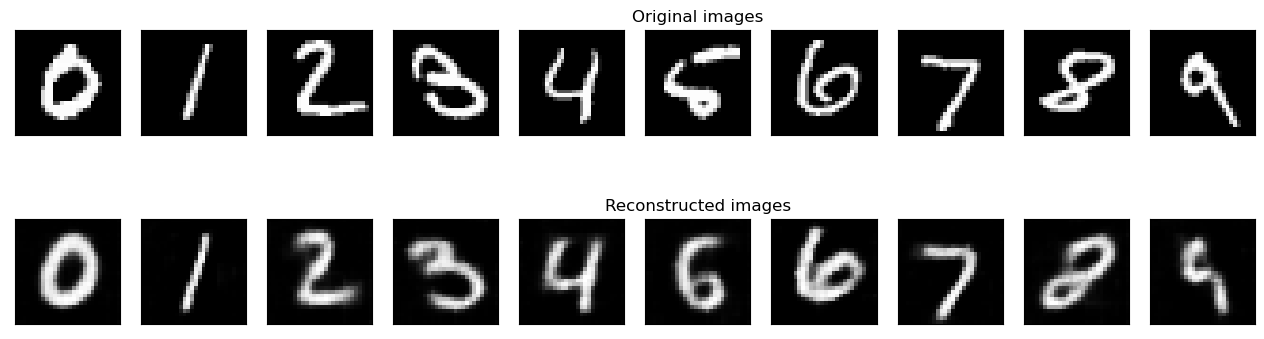

	 partial train loss (single batch): 0.025033
	 partial train loss (single batch): 0.024736
	 partial train loss (single batch): 0.026408
	 partial train loss (single batch): 0.024988
	 partial train loss (single batch): 0.027370
	 partial train loss (single batch): 0.024260
	 partial train loss (single batch): 0.025897
	 partial train loss (single batch): 0.025621
	 partial train loss (single batch): 0.026112
	 partial train loss (single batch): 0.025472
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.026489
	 partial train loss (single batch): 0.025271
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.025536
	 partial train loss (single batch): 0.026455
	 partial train loss (single batch): 0.027009
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.027216
	 partial train loss (single batch): 0.025398
	 partial train loss (single batch): 0.025978
	 partial train loss (single batch

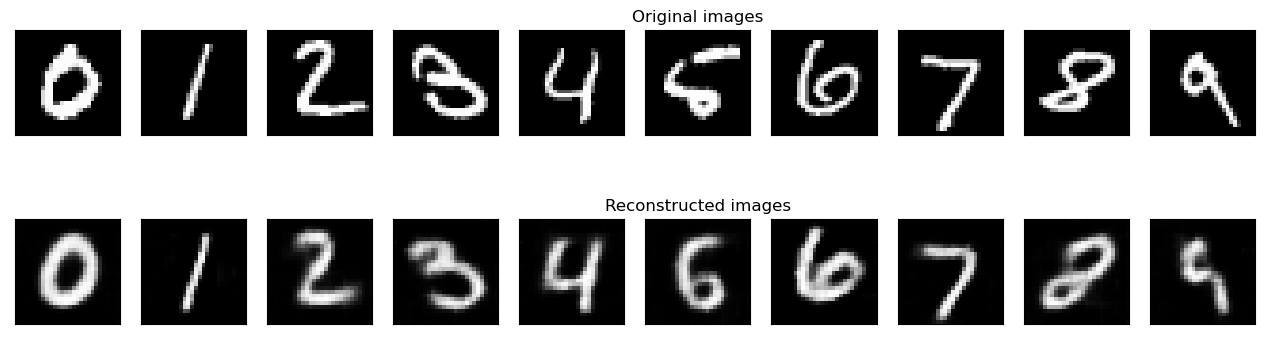

	 partial train loss (single batch): 0.024942
	 partial train loss (single batch): 0.024669
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.024890
	 partial train loss (single batch): 0.027352
	 partial train loss (single batch): 0.024173
	 partial train loss (single batch): 0.025770
	 partial train loss (single batch): 0.025493
	 partial train loss (single batch): 0.026091
	 partial train loss (single batch): 0.025347
	 partial train loss (single batch): 0.025248
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.025164
	 partial train loss (single batch): 0.026174
	 partial train loss (single batch): 0.025453
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.026032
	 partial train loss (single batch): 0.027179
	 partial train loss (single batch): 0.025293
	 partial train loss (single batch): 0.025949
	 partial train loss (single batch

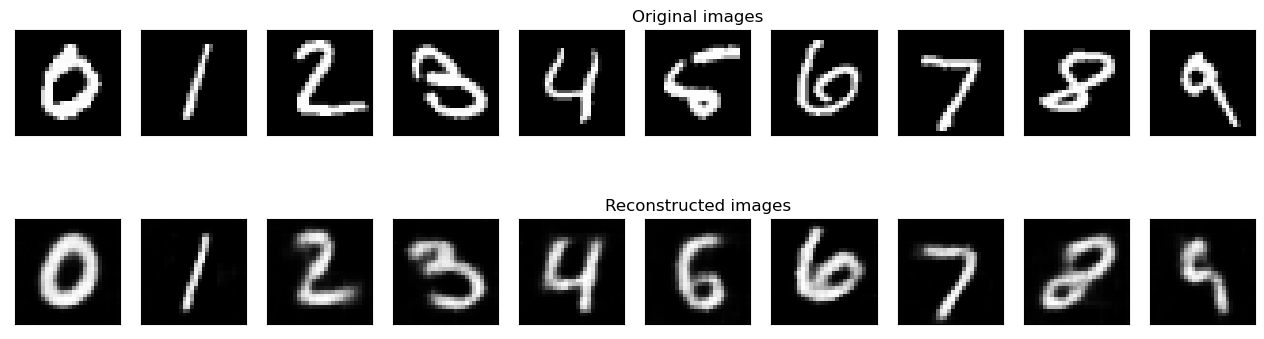

	 partial train loss (single batch): 0.024872
	 partial train loss (single batch): 0.024683
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.024825
	 partial train loss (single batch): 0.027312
	 partial train loss (single batch): 0.024145
	 partial train loss (single batch): 0.025648
	 partial train loss (single batch): 0.025430
	 partial train loss (single batch): 0.025968
	 partial train loss (single batch): 0.025284
	 partial train loss (single batch): 0.025141
	 partial train loss (single batch): 0.026391
	 partial train loss (single batch): 0.025184
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.025402
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch): 0.026894
	 partial train loss (single batch): 0.025942
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.025201
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch

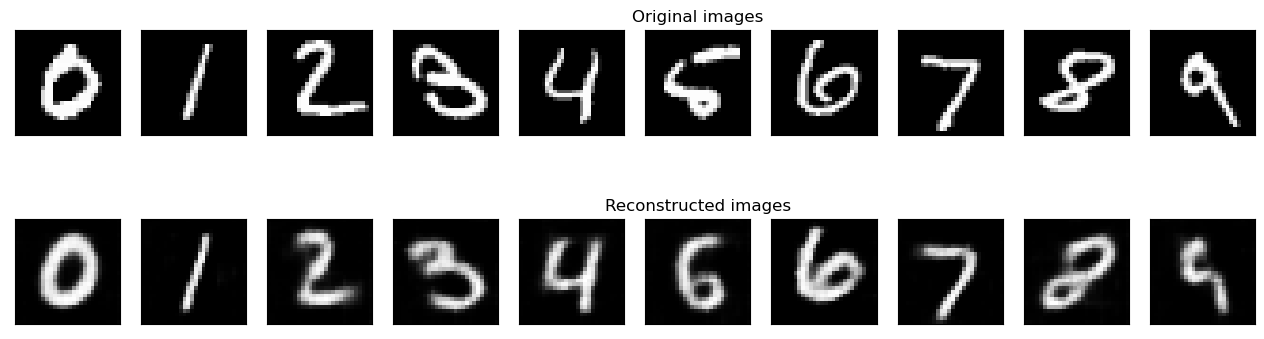

In [13]:

num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

It’s possible to notice that the autoencoder is able to reconstruct well the images after 30 epochs, even if there are some imperfections. But since this model is really simple, it performed very well. Now the model is trained and we want to do a final evaluation of the test set:

In [14]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02628754824399948

We can also observe how the reconstruction losses decrease over the epochs:

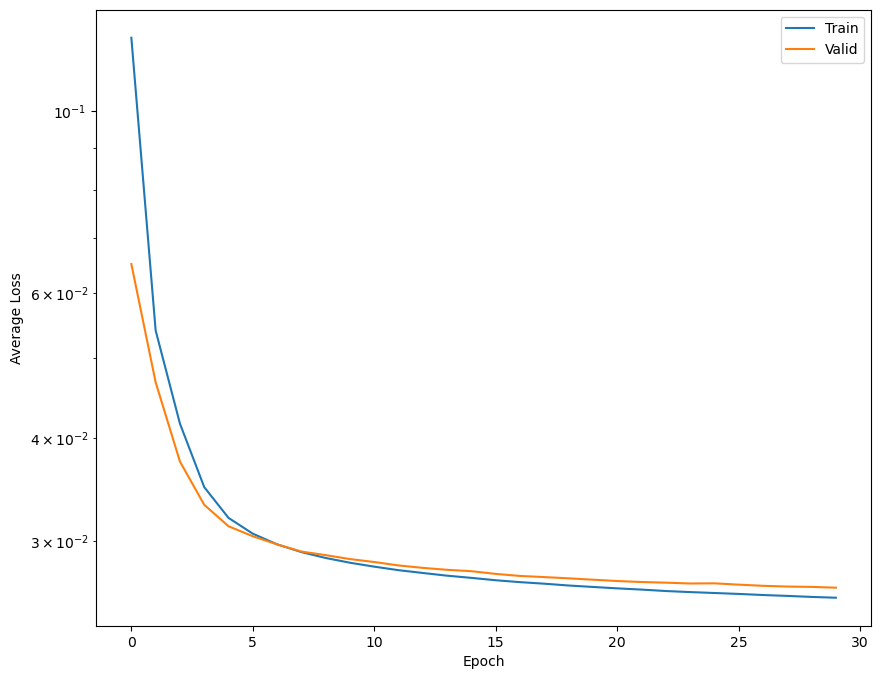

In [15]:

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

5. Generate new samples from the random latent code
To generate new images from the latent code, we sample randomly from a normal distribution with the mean and standard deviation of the encoded data. These samples will be passed to the decoder, which will create the reconstructed images.

tensor([-0.2210,  0.2541,  0.1630,  0.1670])
tensor([0.7718, 0.5904, 0.7280, 0.5768])


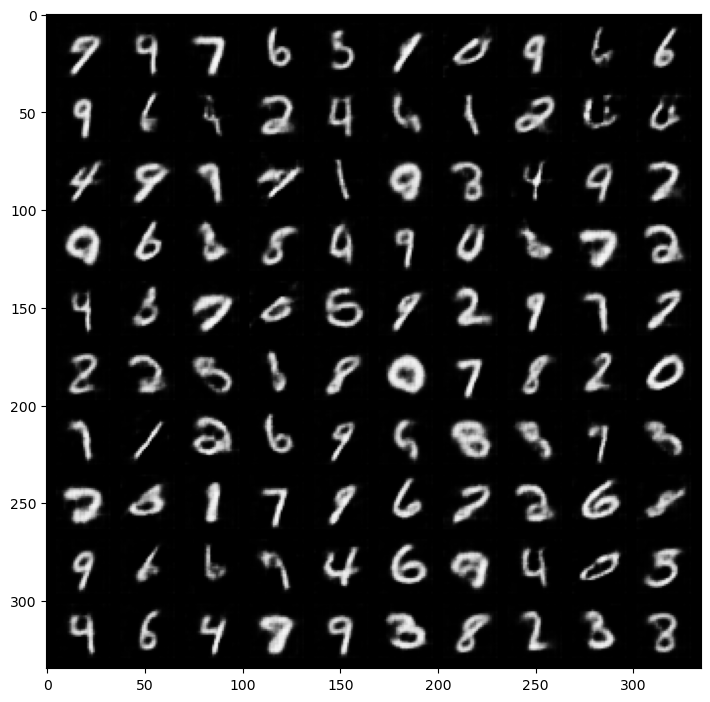

In [17]:

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader)) #Changed in recent update to next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

It should notice that this procedure allows the sampling to be in the same region as the latent code but at the same time there are digits that make no sense. This aspect is explained by the fact that the latent space of the autoencoder is extremely irregular: close points in the latent space can produce very different and meaningless patterns over visible units. For this reason, the autoencoder doesn’t perform well for generative purposes.

6. Visualize the latent space with t-SNE
After we can observe dynamic visualization to see the latent space learned by the autoencoder. First, we create the encoded samples using the test set.

In [20]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:04<00:00, 2188.70it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.061852,1.341081,1.220851,0.162486,7
1,0.553176,0.599300,0.990626,0.363985,2
2,-0.193758,0.955700,0.493065,1.681191,1
3,-0.241066,-0.525638,-0.486852,-0.502362,0
4,-0.834054,0.396382,-1.012897,-0.148504,4
...,...,...,...,...,...
9995,-0.100274,0.502066,1.665966,0.379730,2
9996,0.526559,0.344073,0.723541,-0.168058,3
9997,-1.035004,0.223703,-0.417191,0.650563,4
9998,-0.118418,-0.512140,0.138127,0.437336,5


Let’s plot the latent space representation using plotly express library:

In [22]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

From this plot, we see that similar digits are clustered together. For example “4” overlap with “9” and “5”.

In order to have an easier representation to read, we can apply a dimensionality reduction, called t-SNE, to visualize the latent code in a 2d space. We’ll fix the number of components equal to 2 for this reason.



In [23]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

c:\Users\Mikkel Groengaard\anaconda3\envs\chatbot\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Mikkel Groengaard\anaconda3\envs\chatbot\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



You can see that it distinguishes clearly one digit from the other. There are some exceptions with points that fall in other categories, but t-SNE still remains an improvement compared to the previous representation.